# Fermi-LAT data with Gammapy

## Introduction

This tutorial will show you how to work with pepared Fermi-LAT datasets.

The main class to load and handle the data is:

* [gammapy.dataset.FermiLATDataset](http://docs.gammapy.org/en/latest/api/gammapy.datasets.FermiLATDataset.html)


Additionally we will use objects of these types:

* [gammapy.data.EventList](http://docs.gammapy.org/en/latest/api/gammapy.data.EventList.html) for event lists.
* [gammapy.irf.EnergyDependentTablePSF](http://docs.gammapy.org/en/latest/api/gammapy.irf.EnergyDependentTablePSF.html) for the point spread function.
* [gammapy.cube.SkyCube](http://docs.gammapy.org/en/latest/api/gammapy.cube.SkyCube.html) for the galactic diffuse background model. 
* [gammapy.cube.SkyCubeHPX](http://docs.gammapy.org/en/latest/api/gammapy.cube.SkyCubeHPX.html) for the exposure. 

* [gammapy.spectrum.models.TableModel](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.TableModel.html#gammapy.spectrum.models.TableModel) for the isotropic diffuse model.
* [gammapy.image.FermiLATBasicImageEstimator](http://docs.gammapy.org/en/latest/api/gammapy.image.FermiLATBasicImageEstimator.html) for generating a full WCS dataset, that can be used as an input for image based analyses.


## Setup

**IMPORTANT**: For this notebook you have to get the prepared datasets provided in the [gammapy-fermi-lat-data](https://github.com/gammapy/gammapy-fermi-lat-data) repository. Please follow the instructions [here](https://github.com/gammapy/gammapy-fermi-lat-data#get-the-data) to download the data and setup your environment.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from astropy import units as u
from gammapy.datasets import FermiLATDataset
from gammapy.image import SkyImage, FermiLATBasicImageEstimator

## FermiLATDataset class

To access the prepared Fermi-LAT datasets Gammapy provides a convenience class called [FermiLATDataset](http://docs.gammapy.org/en/latest/api/gammapy.datasets.FermiLATDataset.html#gammapy.datasets.FermiLATDataset). It is initialized with a path to an index configuration file, which tells the dataset class where to find the data. Once 
the object is initialized the data can be accessed as properties of this object, which return the corresponding Gammapy data objects for event lists, sky images and point spread functions (PSF). 

So let's start with exploring the Fermi-LAT 2FHL dataset:

In [3]:
# initialize dataset
dataset = FermiLATDataset('$GAMMAPY_FERMI_LAT_DATA/2fhl/fermi_2fhl_data_config.yaml')
print(dataset)

Fermi-LAT 2FHL dataset
Filenames:
  counts  : fermi_2fhl_counts_cube_hpx.fits.gz
  events  : fermi_2fhl_events.fits.gz
  exposure: fermi_2fhl_exposure_cube_hpx.fits.gz
  isodiff : ../isodiff/iso_P8R2_SOURCE_V6_v06.txt
  livetime: fermi_2fhl_livetime_cube.fits.gz
  psf     : fermi_2fhl_psf_gc.fits.gz



## Events

The first data member we will inspect in more detail is the event list. It can be accessed by the `dataset.events` property and returns an instance of the Gammapy [gammapy.data.EventList](http://docs.gammapy.org/en/latest/api/gammapy.data.EventList.html) class:

In [4]:
# access events data member
events = dataset.events
print(events)

EventList info:
- Number of events: 60275
- Median energy: 80340.5078125 MeV



The full event data is available via the `EventList.table` property, which returns an [astropy.table.Table](http://docs.astropy.org/en/stable/api/astropy.table.Table.html#astropy.table.Table) instance. In case of the Fermi-LAT event list this contains all the additional information on positon, zenith angle, earth azimuth angle, event class, event type etc. Execute the following cell to take a look at the event list table: 

In [5]:
events.table

ENERGY,RA,DEC,L,B,THETA,PHI,ZENITH_ANGLE,EARTH_AZIMUTH_ANGLE,TIME,EVENT_ID,RUN_ID,RECON_VERSION,CALIB_VERSION [3],EVENT_CLASS [32],EVENT_TYPE [32],CONVERSION_TYPE,LIVETIME,DIFRSP0,DIFRSP1,DIFRSP2,DIFRSP3,DIFRSP4
MeV,deg,deg,deg,deg,deg,deg,deg,deg,s,,,,,,,,s,,,,,
float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,int32,int32,int16,int16,bool,bool,int16,float64,float32,float32,float32,float32,float32
145927.0,291.662,42.2341,74.5437,11.8678,38.0455,83.5358,55.6387,314.034,239561457.866,4851437,239559565,0,0 .. 0,False .. True,False .. True,0,275.698088974,0.0,0.0,0.0,0.0,0.0
221273.0,46.9858,-40.6389,247.489,-58.8739,34.1051,224.209,68.2524,198.319,239562739.085,7521432,239559565,0,0 .. 0,False .. True,False .. True,0,64.7974931598,0.0,0.0,0.0,0.0,0.0
57709.2,121.841,49.2288,169.868,32.3017,71.5636,34.2925,36.7173,25.5439,239563180.302,8690693,239559565,0,0 .. 0,False .. True,False .. True,0,30.57218647,0.0,0.0,0.0,0.0,0.0
221224.0,83.5626,-4.21744,207.783,-19.0771,20.5089,92.1605,32.3033,239.141,239563382.213,9208424,239559565,0,0 .. 0,False .. True,False .. True,0,27.4125095904,0.0,0.0,0.0,0.0,0.0
698997.0,320.895,-1.32789,51.2218,-33.9718,35.3621,158.741,12.0867,72.2029,239566572.951,2480483,239565645,0,0 .. 0,False .. True,False .. True,0,106.475481123,0.0,0.0,0.0,0.0,0.0
119159.0,318.811,12.3028,62.6361,-24.416,26.5896,213.894,17.7156,23.9409,239572348.06,1725276,239571670,0,0 .. 0,False .. True,False .. True,0,185.346427292,0.0,0.0,0.0,0.0,0.0
56175.6,279.251,47.8835,76.6915,22.0739,29.1034,61.0048,62.1731,321.104,239572763.431,76017,239572736,0,0 .. 0,False .. True,False .. True,0,24.4507339597,0.0,0.0,0.0,0.0,0.0
1.41812e+06,100.311,-47.4481,256.468,-21.2641,61.2256,294.18,90.4753,144.149,239573788.813,1781569,239572736,0,0 .. 0,False .. True,False .. True,0,68.271614641,0.0,0.0,0.0,0.0,0.0


As a short analysis example we will count the number of events above a certain minimum energy: 

In [6]:
# define energy thresholds
energies = [50, 100, 200, 400, 800, 1600] * u.GeV

n_events_above_energy = []

for energy in energies:
    n = (events.energy > energy).sum()
    n_events_above_energy.append(n)   
    print("Number of events above {0:4.0f}: {1:5.0f}".format(energy, n))

Number of events above   50 GeV: 60275
Number of events above  100 GeV: 21874
Number of events above  200 GeV:  8028
Number of events above  400 GeV:  2884
Number of events above  800 GeV:   821
Number of events above 1600 GeV:   113


And plot it against energy:

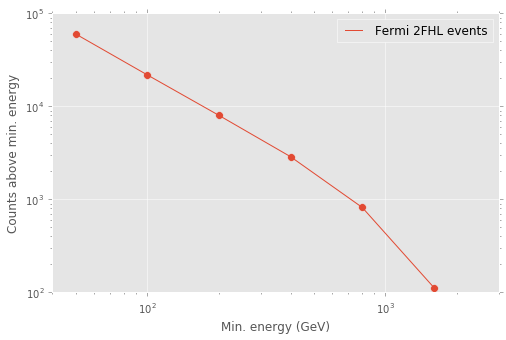

In [7]:
plt.figure(figsize=(8, 5))   
events_plot = plt.plot(energies.value, n_events_above_energy, label='Fermi 2FHL events')
plt.scatter(energies.value, n_events_above_energy, s=60, c=events_plot[0].get_color())
plt.loglog()
plt.xlabel("Min. energy (GeV)")
plt.ylabel("Counts above min. energy")
plt.xlim(4E1, 3E3)
plt.ylim(1E2, 1E5)
plt.legend()

## PSF
Next we will tke a closer look at the PSF. The dataset contains a precomputed PSF model for one position of the sky (in this case the Galactic center). It can be accessed by the `dataset.psf` property and returns an instance of the Gammapy [gammapy.irf.EnergyDependentTablePSF](http://docs.gammapy.org/en/latest/api/gammapy.irf.EnergyDependentTablePSF.html) class:

In [8]:
psf = dataset.psf
print(psf)

EnergyDependentTablePSF
-----------------------

Axis info:
  offset         : size =   300, min =  0.000 deg, max =  9.933 deg
  energy         : size =    17, min = 50.000 GeV, max = 2000.000 GeV
  exposure       : size =    17, min = 184244434125.149 cm2 s, max = 308160738535.443 cm2 s

Containment info:
  68.0% containment radius at  10 GeV: 0.10 deg
  68.0% containment radius at 100 GeV: 0.10 deg
  95.0% containment radius at  10 GeV: 0.52 deg
  95.0% containment radius at 100 GeV: 0.43 deg



To get an idea of the size of the PSF we check how the containment radii of the Fermi-LAT PSF vari with energy and different containment fractions:

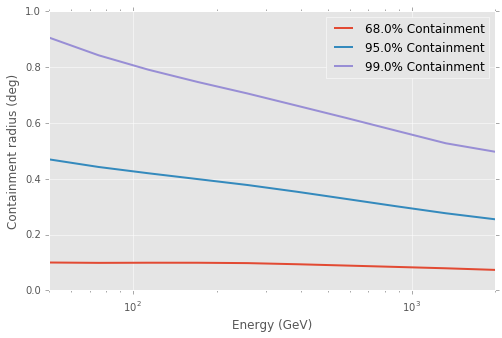

In [9]:
plt.figure(figsize=(8, 5))
psf.plot_containment_vs_energy(linewidth=2, fractions=[0.68, 0.95, 0.99])
plt.xlim(50, 2000)
plt.show()

In addition we can check how the actual shape of the PSF varies with energy and compare it against the mean PSF between 50 GeV and 2000 GeV:

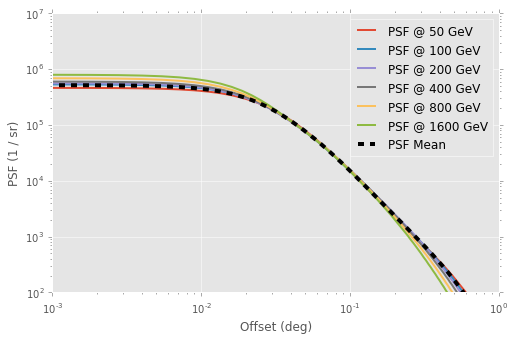

In [10]:
plt.figure(figsize=(8, 5))

for energy in energies:
    psf_at_energy = psf.table_psf_at_energy(energy)
    psf_at_energy.plot_psf_vs_theta(label='PSF @ {:.0f}'.format(energy), lw=2)

erange = [50, 2000] * u.GeV
psf_mean = psf.table_psf_in_energy_band(energy_band=erange, spectral_index=2.3)
psf_mean.plot_psf_vs_theta(label='PSF Mean', lw=4, c="k", ls='--')
    
plt.xlim(1E-3, 1)
plt.ylim(1E2, 1E7)
plt.legend()

## Exposure
The Fermi-LAT datatset contains the energy-dependent exposure for the whole sky stored using a HEALPIX pixelisation of the sphere. It can be accessed by the `dataset.exposure` property and returns an instance of the Gammapy [gammapy.cube.SkyCubeHPX]() class:

In [11]:
exposure = dataset.exposure
print(exposure)

Healpix sky cube exposure with shape=(18, 12288) and unit=cm2 s:
 n_pix:    12288  coord_type:    galactic         coord_unit:    deg
 n_energy:    18  unit_energy: MeV



In [12]:
# define reference image using a cartesian projection
image_ref = SkyImage.empty(nxpix=360, nypix=180, binsz=1, proj='CAR')

# reproject HEALPIC sky cube
exposure_reprojected = exposure.reproject(image_ref)

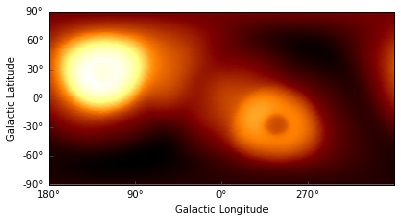

<function gammapy.cube.core.SkyCube.show.<locals>.show_image>

In [13]:
exposure_reprojected.show()

You can use the slider to slide through the different energy bands.

## Galactic diffuse background

The Fermi-LAT collaboration provides a galactic diffuse emission model, that can be used as a background model for
Fermi-LAT data analysis. Currently Gammapy only supports the latest model (`gll_iem_v06.fits`). It can be accessed by the `dataset.galactic_diffuse` property and returns an instance of the Gammapy [gammapy.cube.SkyCube](http://docs.gammapy.org/en/latest/api/gammapy.cube.SkyCube.html) class:

In [14]:
galactic_diffuse = dataset.galactic_diffuse
print(galactic_diffuse)

Sky cube galactic diffuse with shape=(30, 1441, 2880) and unit=1 / (cm2 MeV s sr):
 n_lon:     2880  type_lon:    GLON-CAR         unit_lon:    deg
 n_lat:     1441  type_lat:    GLAT-CAR         unit_lat:    deg
 n_energy:    30  unit_energy: MeV



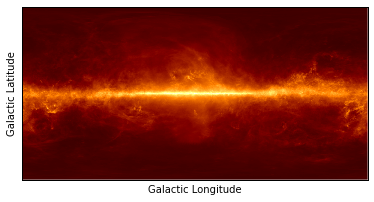

<function gammapy.cube.core.SkyCube.show.<locals>.show_image>

In [15]:
norm = image_ref.plot_norm(stretch='log', clip=True)
galactic_diffuse.show(norm=norm)

Again you can use the slider to slide through the different energy bands. E.g. note how the Fermi-Bubbles become more present at higher energies (higher value of idx).

## Isotropic diffuse background

Additionally to the galactic diffuse model, there is an isotropic diffuse component. It can be accessed by the `dataset.isotropic_diffuse` property and returns an instance of the Gammapy [gammapy.spectrum.models.TableModel](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.TableModel.html#gammapy.spectrum.models.TableModel) class:

In [16]:
isotropic_diffuse = dataset.isotropic_diffuse
print(isotropic_diffuse)

TableModel
ParameterList
Parameter(name='amplitude', value=1, unit='', min=0, max=None, frozen=False)

Covariance: None


We can plot the model in the energy range between 50 GeV and 2000 GeV:

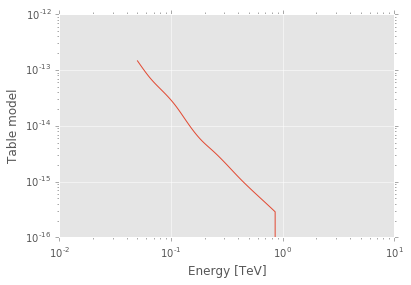

In [17]:
erange = [50, 2000] * u.GeV
isotropic_diffuse.plot(erange)

## Estimating basic input sky images for high level analyses
Finally we'd like to use the prepared 2FHL dataset to generate a set of basic sky images, that a can be used as input for high level analyses, e.g. morphology fits, region based flux measurements, computation of significance images etc.
For this purpose Gammapy provides a convenience class called [gammapy.image.FermiLATBasicImageEstimator](http://docs.gammapy.org/en/latest/api/gammapy.image.FermiLATBasicImageEstimator.html). First we define a reference image, that specifies the region we'd like to analyse. In this case we choose the Vela region.

In [18]:
image_ref = SkyImage.empty(nxpix=360, nypix=180, binsz=0.05, xref=265, yref=0)

Next we choose the energy range and initialize the `FermiLATBasicImageEstimator` object:

In [19]:
emin, emax = [50, 2000] * u.GeV
image_estimator = FermiLATBasicImageEstimator(reference=image_ref, emin=emin, emax=emax)

Finally we run the image estimation by calling `.run()` and parsing the dataset object:

In [20]:
images_basic = image_estimator.run(dataset)

The image estimator now computes a set of sky images for the reference region and energy range we defined above. The result `images_basic` is a [gammapy.image.SkyImageList](http://docs.gammapy.org/en/latest/api/gammapy.image.SkyImageList.html) object containing the following images:

* **counts**: counts image containing the binned event list
* **background**: predicted number of background counts computed from the sum of the galactic and isotropic diffuse model, given the exposure.
* **exposure**: integrated exposure assuming a powerlaw with spectral index 2.3 in the given energy range
* **excess**: backround substracted counts image
* **flux**: measured flux, computed from excess divided by exposure
* **psf**: sky image of the exposure weighted mean PSF in the given energy range
    
You can check the contained images as following:

In [21]:
images_basic.names

['counts', 'background', 'exposure', 'excess', 'flux', 'psf']

To check whether the image estimation was succesfull we'll take a look at the flux image, smoothing it in advance with a Gaussian kernel of 0.2 deg:

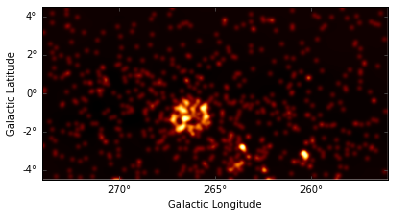

In [22]:
smoothed_flux = images_basic['flux'].smooth(kernel='gauss', radius=0.2 * u.deg)
smoothed_flux.show()

## Exercises

- Try to reproject the exposure using an `AIT` projection.
- Try to find the spectral index of the isotropic diffuse model using a method off the `TableModel` instance.
- Compute basic sky images for different regions (e.g. Galactic Center) and energy ranges


## What next?

In this tutorial we have learned how to access and check Fermi-LAT data.

Next you could do:
* image analysis
* spectral analysis
* cube analysis
* time analysis
* source detection